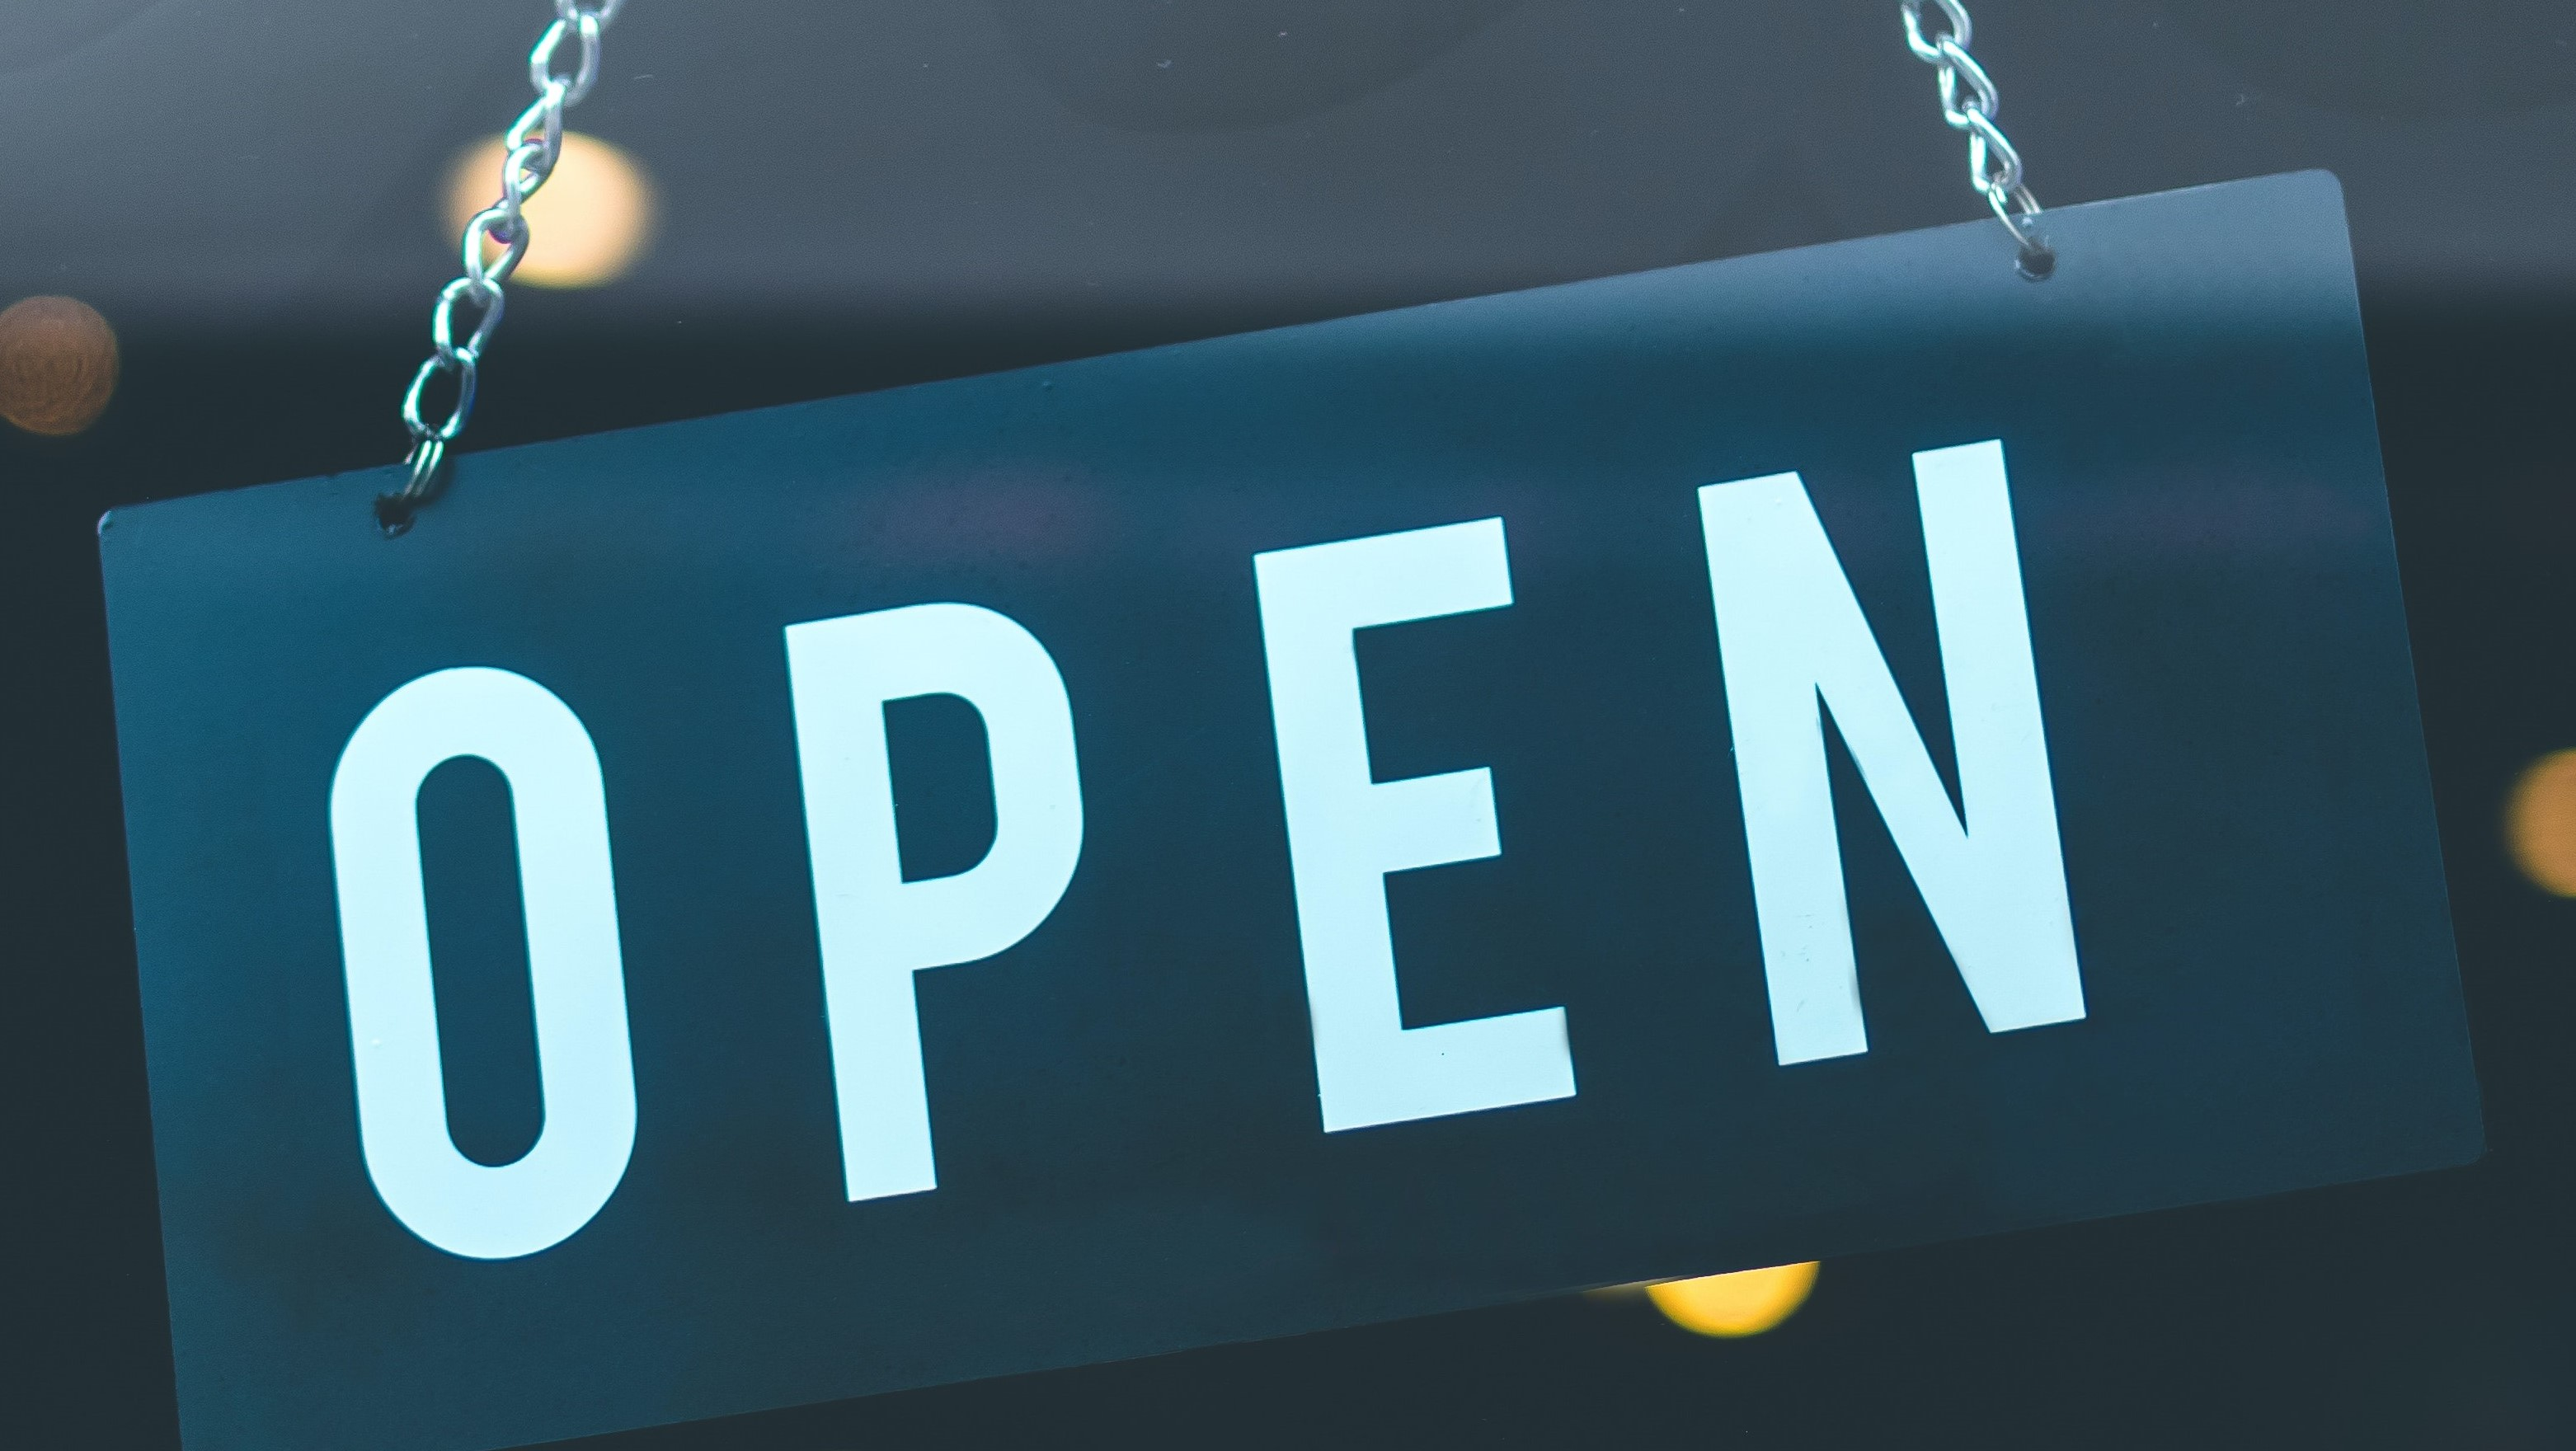

<a id = "1"></a><h1 id="Salary Prediction with Machine Learning"><span class="label label-default" style="background-color:#f5c0c0; font-size:30px; 
color: Black; ">Store Item Demand Forecasting</span></h1>
**This competition is provided as a way to explore different time series techniques on a relatively simple and clean dataset.**

**You are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores.**



<a id = "1"></a><h1 id="Salary Prediction with Machine Learning"><span class="label label-default" style="background-color:#f5c0c0; font-size:30px; 
color: Black; ">Variables</span></h1>


- date
- store
- item
- sales



<a id = "1"></a><h1 id="Salary Prediction with Machine Learning"><span class="label label-default" style="background-color:#f5c0c0; font-size:30px; 
color: Black; ">Importing Libraries</span></h1>

In [ ]:
# Gerekli Kütüphaneler ve Ayarlar

import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import itertools

import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

<a id = "1"></a><h1 id="Salary Prediction with Machine Learning"><span class="label label-default" style="background-color:#f5c0c0; font-size:30px; 
color: Black; ">Exploring Data Analysis</span></h1>

In [ ]:
#load dataset
train = pd.read_csv('../input/demand-forecasting-kernels-only/train.csv', parse_dates=['date'])
test = pd.read_csv('../input/demand-forecasting-kernels-only/test.csv', parse_dates=['date'])
df = pd.concat([train, test], sort=False) # veri önişleme için test ve train bir araya getirdim
df.head()

In [ ]:
print("Train setinin boyutu:",train.shape)
print("Test setinin boyutu:",test.shape)

In [ ]:
df.shape

In [ ]:
df.quantile([0, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1]).T

In [ ]:
df["date"].min()

In [ ]:
df["date"].max()

In [ ]:
# Satış dağılımı
df["sales"].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])

In [ ]:
# Mağaza sayısı
df["store"].nunique()

In [ ]:
#Ürün sayısı
df["item"].nunique() 

In [ ]:
# Her mağazadaki eşsiz ürün eşit sayıda mı?
df.groupby(["store"])["item"].nunique()

In [ ]:
# Mağaza-ürün kırılımında satış istatistikleri
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

<a id = "1"></a><h1 id="Salary Prediction with Machine Learning"><span class="label label-default" style="background-color:#f5c0c0; font-size:30px; 
color: Black; ">Feature Engineering</span></h1>

In [ ]:
# hangi ayda satış yapılmış
df['month'] = df.date.dt.month
# ayın hangi gününde satış yapılmış
df['day_of_month'] = df.date.dt.day
# yılın hangi gününde satış yapılmış
df['day_of_year'] = df.date.dt.dayofyear 
# yılın hangi haftasında satış yapılmış
df['week_of_year'] = df.date.dt.weekofyear
# haftanın hangi gününde satış yapılmış
df['day_of_week'] = df.date.dt.dayofweek
# hangi yılda satış yapılmış
df['year'] = df.date.dt.year
# haftasonu mu değil mi
df["is_wknd"] = df.date.dt.weekday // 4
# ayın başlangıcı mı
df['is_month_start'] = df.date.dt.is_month_start.astype(int)
# ayın bitişi mi
df['is_month_end'] = df.date.dt.is_month_end.astype(int) 

In [ ]:
df.head()

In [ ]:
# store-item-month kırılımında satış istatistikleri
df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

<a id = "1"></a><h1 id="Salary Prediction with Machine Learning"><span class="label label-default" style="background-color:#f5c0c0; font-size:30px; 
color: Black; ">Random Noise (Gürültü)</span></h1>

In [ ]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

<a id = "1"></a><h1 id="Salary Prediction with Machine Learning"><span class="label label-default" style="background-color:#f5c0c0; font-size:30px; 
color: Black; ">Lag/Shifted Features (Gecikmeler)</span></h1>

In [ ]:
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)
df.head()

In [ ]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

<a id = "1"></a><h1 id="Salary Prediction with Machine Learning"><span class="label label-default" style="background-color:#f5c0c0; font-size:30px; 
color: Black; ">Rolling Mean Features (Hareketli Ortalamalar)</span></h1>

In [ ]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [365, 546, 730])

<a id = "1"></a><h1 id="Salary Prediction with Machine Learning"><span class="label label-default" style="background-color:#f5c0c0; font-size:30px; 
color: Black; ">Exponentially Weighted Mean Features (Üssel Ağırlıklı Ortalama Featureları)</span></h1>

In [ ]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


alphas = [0.99, 0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)
df.tail()

In [ ]:
#One-Hot Encoding

df = pd.get_dummies(df, columns=['day_of_week', 'month'])

In [ ]:
#Converting sales to log(1+sales)

df['sales'] = np.log1p(df["sales"].values)

<a id = "1"></a><h1 id="Salary Prediction with Machine Learning"><span class="label label-default" style="background-color:#f5c0c0; font-size:30px; 
color: Black; ">LightGBM Model</span></h1>

In [ ]:
# 2017'nin başına kadar (2016'nın sonuna kadar) train seti.
train = df.loc[(df["date"] < "2017-01-01"), :]

# 2017'nin ilk 3'ayı validasyon seti.
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

# bağımsız değişkenler
cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

In [ ]:
# train seti için bağımlı değişkenin seçilmesi
Y_train = train['sales']

# train seti için bağımsız değişkenin seçilmesi
X_train = train[cols]

# validasyon seti için bağımlı değişkenin seçilmesi
Y_val = val['sales']

# validasyon seti için bağımsız değişkenin seçilmesi
X_val = val[cols] 

# kontrol
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

<a id = "1"></a><h1 id="Salary Prediction with Machine Learning"><span class="label label-default" style="background-color:#f5c0c0; font-size:30px; 
color: Black; ">Custom Cost Function</span></h1>

In [ ]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [ ]:
# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000, 
              'early_stopping_rounds': 200,
              'nthread': -1}

In [ ]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape, # hatyı gözlemliyoruz
                  verbose_eval=100)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

# validasyon hatasının yüzdesi
smape(np.expm1(y_pred_val), np.expm1(Y_val))

In [ ]:
#Final Model

# test ve train bağımlı/bağımsız değişkenlerinin belirlenmesi

train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

test = df.loc[df.sales.isna()]
X_test = test[cols]

In [ ]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)
test_preds = model.predict(X_test, num_iteration=model.best_iteration)

In [ ]:
#1. mağazanın 1.ürünleri için yapılan tahminler

forecast = pd.DataFrame({"date":test["date"],
                        "store":test["store"],
                        "item":test["item"],
                        "sales":test_preds
                        })

forecast[(forecast.store == 1) & (forecast.item == 1)].set_index("date").sales.plot(color = "green",
                                                                                    figsize = (20,9),
                                                                                    legend=True, label = "Store 1 Item 1 Forecast");

In [ ]:
#1.Mağazanın 17. Ürünü İçin Tahmin Edilen Değerler

train[(train.store == 1) & (train.item == 17)].set_index("date").sales.plot(figsize = (20,9),legend=True, label = "Store 1 Item 17 Sales")
forecast[(forecast.store == 1) & (forecast.item == 17)].set_index("date").sales.plot(legend=True, label = "Store 1 Item 17 Forecast");

In [ ]:
df.shape

<div style="display:fill;
            border-radius: false;
            border-style: solid;
            border-color:;
            border-style: false;
            border-width: 2px;
            color:;
            font-size:15px;
            font-family: Georgia;
            background-color:#ACCDA7;
            text-align:center;
            letter-spacing:0.1px;
            padding: 0.1em;">

**<h2>THANK YOU FOR TAKING THE TIME**